## The basic model of virus dynamics

The basic model for virus dynamics is:

$$ \dot{x} = \lambda - d x - \beta x v $$
$$ \dot{y} = \beta x v - a y $$
$$ \dot{v} = ky - uv $$

where $\lambda$ is the constant rate of replishment of susceptible cells, $d$ is the death rate of susceptible cells, $a$ is the death rate of infected cells, $u$ is the clearance rate of virus, $k/a$ is the burst size (# of viruses produced by infected cells over their lifespan), and $\beta$ is the per contact rate at which susceptible cells become infected by virus.

## Steady state assumption for $v$

If $u >> a$, then to a good approximation, $v$ is in a steady state ($\dot{v} = 0$). In that case, the viral load is proportional to the concentration of infected cells $v = k y / u$. Let $b = \beta k / u$, then we have the reduced system:

$$ \dot{x} = \lambda - dx - b x y$$
$$ \dot{y} = b x y - ay $$

(This is all directly as written in Nowak Virus Dynamics 10.4-10.5.) Below we will refer to this as the $v$ steady-state model.

## Drug resistant mutant

Suppose that there are two strains of the virus $y_s$ and $y_r$, the former which is susceptible to an anti-viral drug and the latter which is resistant. Then our system, with the steady-state approximation for $v$, becomes:

$$ \dot{x} = \lambda - d x - (s b_s y_s + b_r y_r) x $$
$$ \dot{y_s} = (s b_s x - a) y_s $$
$$ \dot{y_r} = (b_r x - a) y_r $$

where $s \in [0, 1]$ is a parameter that characterizes the drug's inhibition of infection of susceptibles by the sensitive virus.

So far, this is all exactly as written in Novak 2000. Let us introduce the additional term of a mutation rate $\mu << 1$, where mutation occurs at the point of infection:

$$ \dot{x} = \lambda - d x - (s b_s y_s + b_r y_r) x $$
$$ \dot{y_s} = (s b_s (1 - \mu) x - a) y_s \approx (s b_s x - a) y_s $$
$$ \dot{y_r} = (b_r x + s b_s \mu - a) y_r $$

We will refer to this as the $v$ steady-state model with drug.

## Latency

A topic of huge importance in the context of HIV is the latent reservoir: quiescent CD4+ T-cells that harbor HIV virus in their genome.

## Experiments:

- Probability / unit time that a mutant emerges when wildtype is at a low level due to treatment. [Might have to introduce new term to prop it up without latency.]
- Diffusion process: ignore mutation. Given $n$ initial copies of wildtype and $R_0$ of blah (might depend on the absolute magnitudes of the birth/death rates as well), what is the mean and ~~variance~~ [index of dispersion](https://stats.stackexchange.com/questions/203766/use-cases-for-coefficient-of-variation-vs-index-of-dispersion) of the population of the wildtype after $t$ time passes. Maybe the strictest version of this scenario is to start the wildtype at its mean value.
  - variant 1: virus is at low level (survives only due to reactivation from latency)
  - variant 2: virus is at SPVL
  - variant 3: virus is at low level, but $R_0$ jumps to being greater than one at $t = 0$.
- Race to rescue: given $n$ initial copies of wildtype and active inhibition by drug, what is the distribution of times of emergence of a mutant which survives stochastic extinction (a rescue mutant).
- The GOAT experiment: seed $n$ initial copies of wildtype, let it grow [?] until some point in time. Then introduce drug and mutation. What is the probability of a mutant emerges. Depends on (1) inherent large-scale fluctuations in # of infected cells (Langevin regime essentially) (2) low level stochasticity of race to rescue. Am I sure everything doesn't wash out due to reducing observation down to one quantity (probability of emergence). Maybe instead look at the distribution of times that a rescue mutant emerges!

In [1]:
from reactionmodel.model import Species, Reaction, Model

x  = Species('x')
ys = Species('y_s')
yr = Species('y_r')

reactions = []
reactions.append(Reaction([x], [], k='d'))
reactions.append(Reaction([], [x], k='l'))
reactions.append(Reaction([ys], [], k='a'))
reactions.append(Reaction([yr], [], k='a'))
reactions.append(Reaction([x, ys], [(ys, 2)], k='s*b_s'))
reactions.append(Reaction([x, yr], [(yr, 2)], k='b_r'))
reactions.append(Reaction([x, ys], [ys, yr], k='s*b_s*mu'))

m = Model([x, ys, yr], reactions)

In [25]:
p = {
    'd': 0.05,
    'a': 1.0,
    'l': 1e10,
    's': .33,
    'mu': 1e-5,
    'b_s': 3e-11,
    'b_r': 2e-11,
}

y0 = m.make_initial_condition(
    {
        'x': 'l/d',
        'y_s': 1,
        'y_r': 0
    },
    parameters=p
)

Evaluating expression: l/d => 200000000000.0


Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 9.900000000000001e-12
Evaluating expression: b_r => 2e-11
Evaluating expression: s*b_s*mu => 9.900000000000002e-17


(1, 1000000000000.0)

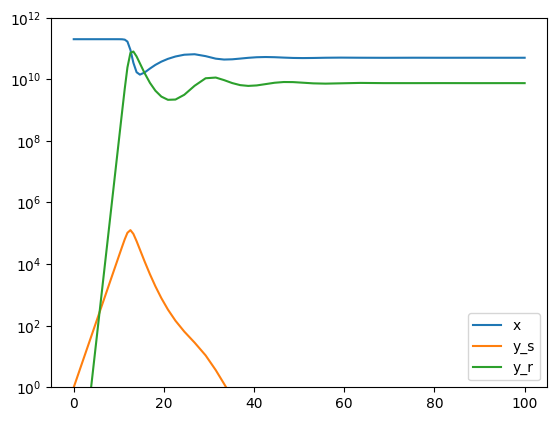

In [26]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

result = solve_ivp(m.get_dydt(jit=False, parameters=p), [0.0, 100.0], y0)

ax = plt.subplot()
ax.plot(result.t, result.y.T)
ax.legend([s.name for s in m.species])
ax.set_yscale('log')
ax.set_ylim([1, 1e12])

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 9.900000000000001e-12
Evaluating expression: b_r => 2e-11
Evaluating expression: s*b_s*mu => 9.900000000000002e-17


(1, 1000000000000.0)

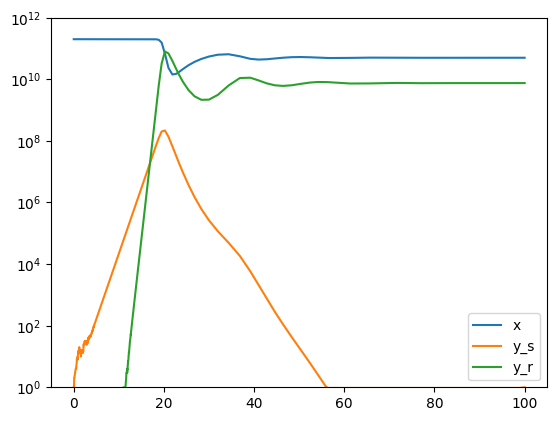

In [33]:
import numpy as np
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

s = HybridSimulator(
    m.get_k(parameters=p, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

result = s.simulate([0.0, 100.0], y0, np.random.default_rng())

ax = plt.subplot()
ax.plot(result.t_history, result.y_history.T)
ax.legend([s.name for s in m.species])
ax.set_yscale('log')
ax.set_ylim([1, 1e12])

In [2]:
from hybrid.gillespie import GillespieSimulator

GillespieSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

MissingParametersError: attempted to get k(t) without a parameter dictionary where at least one rate constant was a lazy expression that needs a parameter dictionary to be evaluated

### Subquestion:

In [21]:
a = Species('A')
b = Species('B')
r1 = Reaction([a], [b], k='k')
r2 = Reaction([b], [a], k='k')
m = Model([a, b], [r1, r2])

In [32]:
import numpy as np
from hybrid.gillespie import GillespieSimulator

parameters = {'k': 1}

s = GillespieSimulator(
    m.get_k(parameters=parameters),
    m.stoichiometry(),
    m.kinetic_order(),
)

result = s.simulate(
    [0.0, 200.0],
    m.make_initial_condition({'A': 200, 'B': 200}),
    rng=np.random.default_rng()
)

Evaluating expression: k => 1.0
Evaluating expression: k => 1.0


Per Gillespie, it's a known rule of thumb in chemistry and a mathematically exact result in the Langevin regime that the fluctuations caused by the mean 0 stochastic effects are on the order of $\sqrt{N}$ for a reaction involving a species with population size $N$, whereas the deterministic part has mean proportional to the population size. Therefore the **ratio** of the stochastic effects to the deterministic ones is $N^{-1/2}$.

"The relative fluctuations in the time-evolving species populations scale as the inverse square-root of the reactant populations." A fact that "follows simply from the fact that the standard deviation of a Poisson random variable is always equal to the square root of its mean."

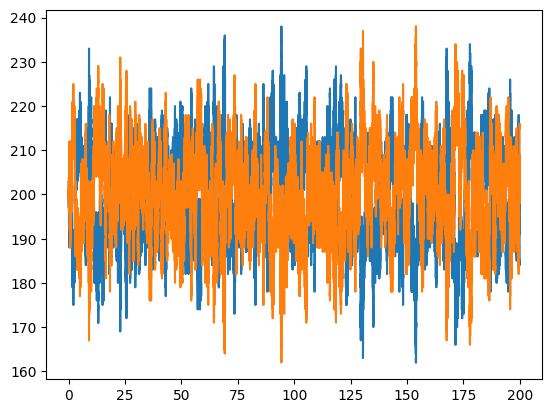

In [33]:
import matplotlib.pyplot as plt

plt.plot(result.t_history, result.y_history.T)


Possible approaches:

- Tri-partitioned into deterministic, Langevin (or tau-leaping), and Gillespie. If we could assume that the propensities are constant between stochastic events, then we could know in advance the hitting time of the stochastic subnet, in which case we would know for what rates that amounts to acceptable time step for a Langevin approximation (recall we need (i) the likely number of reactions occurring for each relevant species is much smaller than the reactant populations (a subset of propensities not changing appreciably and therefore guaranteed by assumption) and (ii) each reaction to fire multiple times.). And since these involve species counts, maybe we can use it to help construct a bridge between partitioning based on # and partitioning based on propensity